# 0. Introduction

# 1. Initialization

## 1.1. (most) package imports

In [1]:
# kaggle/python Docker image: https://github.com/kaggle/docker-python

import gc
import time
import os
import re
from contextlib import contextmanager
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from IPython.display import clear_output

import math
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 20, "display.max_columns", 30)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
import imblearn.pipeline
#from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

from sklearn.dummy import DummyClassifier
#from sklearn.utils.testing import ignore_warnings # For LogisticRegression
#from sklearn.exceptions import ConvergenceWarning # For LogisticRegression
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import shap

## 1.2. Global variables

In [2]:
offline = True

## 1.3. Global functions

In [3]:
@contextmanager
def timer(title):
    t0 = time.perf_counter()
    yield
    print("{} - done in {:.0f}s".format(title, time.perf_counter() - t0))

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## 1.4. Dataset overview

offline j'ai:

<p style="background:black">
<code style="background:black;color:white">filenames = [
    "home-credit-default-risk/application_test.csv",
    "home-credit-default-risk/application_train.csv",
    "home-credit-default-risk/bureau.csv",
    "home-credit-default-risk/bureau_balance.csv",
    "home-credit-default-risk/credit_card_balance.csv",
    "home-credit-default-risk/installments_payments.csv",
    "home-credit-default-risk/POS_CASH_balance.csv",
    "home-credit-default-risk/previous_application.csv",
    "home-credit-default-risk/sample_submission.csv"
    ]
</code>
</p>

not offline (on Kaggle) j'ai:

<p style="background:black">
<code style="background:black;color:white">filenames = [
    "/kaggle/input/home-credit-default-risk/sample_submission.csv",
    "/kaggle/input/home-credit-default-risk/bureau_balance.csv",
    "/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv",
    "/kaggle/input/home-credit-default-risk/application_train.csv",
    "/kaggle/input/home-credit-default-risk/application_test.csv",
    "/kaggle/input/home-credit-default-risk/previous_application.csv",
    "/kaggle/input/home-credit-default-risk/credit_card_balance.csv",
    "/kaggle/input/home-credit-default-risk/installments_payments.csv",
    "/kaggle/input/home-credit-default-risk/bureau.csv"]
    ]
</code>
</p>

In [4]:
if offline:
    le_path = "home-credit-default-risk/"
else:
    le_path = "/kaggle/input"

In [5]:
filenames = []
for dirname, _, filenamess in os.walk(le_path):
    for filenamee in filenamess:
#                        HomeCredit_columns_description.csv est illisible.
        if filenamee != "HomeCredit_columns_description.csv":
            filename = os.path.join(dirname, filenamee)
#            print(filename)
            filenames.append(filename)
#            df = pd.read_csv(filename)
#            display(df[-1:])

In [6]:
if not offline:
    flnms = []
    flnms.append(filenames[4])
    flnms.append(filenames[3])
    flnms.append(filenames[8])
    flnms.append(filenames[1])
    flnms.append(filenames[6])
    flnms.append(filenames[7])
    flnms.append(filenames[2])
    flnms.append(filenames[5])
    flnms.append(filenames[0])
    filenames = flnms

# 2. Preprocessing

## 2.1. application_train and application_test

In [7]:
def application_train_test(num_rows=None, nan_as_category=False):
    df = pd.read_csv(filenames[1], nrows=num_rows)
    test_df = pd.read_csv(filenames[0], nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()

    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df["CODE_GENDER"] != "XNA"]

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # Aberrant values
    df["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

    # Some simple new features (percentages)
    df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]

    del test_df
    gc.collect()
    return df

## 2.2. bureau and bureau_balance

In [8]:
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv(filenames[2], nrows=num_rows)
    bb = pd.read_csv(filenames[3], nrows=num_rows)

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {"MONTHS_BALANCE": ["min", "max", "size"]}
    for col in bb_cat:
        bb_aggregations[col] = ["mean"]
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]
    )
    bureau = bureau.join(bb_agg, how="left", on="SK_ID_BUREAU")
    bureau.drop(["SK_ID_BUREAU"], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        "DAYS_CREDIT": ["min", "max", "mean", "var"],
        "DAYS_CREDIT_ENDDATE": ["min", "max", "mean"],
        "DAYS_CREDIT_UPDATE": ["mean"],
        "CREDIT_DAY_OVERDUE": ["max", "mean"],
        "AMT_CREDIT_MAX_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM_LIMIT": ["mean", "sum"],
        "AMT_ANNUITY": ["max", "mean"],
        "CNT_CREDIT_PROLONG": ["sum"],
        "MONTHS_BALANCE_MIN": ["min"],
        "MONTHS_BALANCE_MAX": ["max"],
        "MONTHS_BALANCE_SIZE": ["mean", "sum"]
    }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ["mean"]
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ["mean"]

    bureau_agg = bureau.groupby("SK_ID_CURR").agg(
        {**num_aggregations, **cat_aggregations}
    )
    bureau_agg.columns = pd.Index([
        "BURO_" + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()
    ])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
    active_agg.columns = pd.Index([
        "ACTIVE_" + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
    closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
    closed_agg.columns = pd.Index([
        "CLOSED_" + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()
    ])
    bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")
    del closed, closed_agg, bureau
    gc.collect()

    return bureau_agg

## 2.3. previous_applications

In [9]:
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv(filenames[7], nrows=num_rows)

    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Aberrant values
    prev["DAYS_FIRST_DRAWING"].replace(365243, np.nan, inplace=True)
    prev["DAYS_FIRST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE_1ST_VERSION"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_TERMINATION"].replace(365243, np.nan, inplace=True)

    # Add feature: value ask / value received percentage
    prev["APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / prev["AMT_CREDIT"]

    # Previous applications numeric features
    num_aggregations = {
        "AMT_ANNUITY": ["min", "max", "mean"],
        "AMT_APPLICATION": ["min", "max", "mean"],
        "AMT_CREDIT": ["min", "max", "mean"],
        "APP_CREDIT_PERC": ["min", "max", "mean", "var"],
        "AMT_DOWN_PAYMENT": ["min", "max", "mean"],
        "AMT_GOODS_PRICE": ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START": ["min", "max", "mean"],
        "RATE_DOWN_PAYMENT": ["min", "max", "mean"],
        "DAYS_DECISION": ["min", "max", "mean"],
        "CNT_PAYMENT": ["mean", "sum"],
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ["mean"]

    prev_agg = prev.groupby("SK_ID_CURR").agg({**num_aggregations,
                                               **cat_aggregations})
    prev_agg.columns = pd.Index([
        "PREV_" + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()
    ])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev["NAME_CONTRACT_STATUS_Approved"] == 1]
    approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
    approved_agg.columns = pd.Index([
        "APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(approved_agg, how="left", on="SK_ID_CURR")

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev["NAME_CONTRACT_STATUS_Refused"] == 1]
    refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
    refused_agg.columns = pd.Index([
        "REFUSED_" + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()
    ])
    prev_agg = prev_agg.join(refused_agg, how="left", on="SK_ID_CURR")

    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

## 2.4. pos_cash

In [10]:
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv(filenames[6], nrows=num_rows)

    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # Features
    aggregations = {
        "MONTHS_BALANCE": ["max", "mean", "size"],
        "SK_DPD": ["max", "mean"],
        "SK_DPD_DEF": ["max", "mean"]
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    pos_agg = pos.groupby("SK_ID_CURR").agg(aggregations)
    pos_agg.columns = pd.Index([
        "POS_" + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()
    ])

    # Count pos cash accounts
    pos_agg["POS_COUNT"] = pos.groupby("SK_ID_CURR").size()

    del pos
    gc.collect()
    return pos_agg

## 2.5. installment_payments

In [11]:
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv(filenames[5], nrows=num_rows)

    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    # Features
    # Percentage and difference paid in each installment (amount paid and
    # installment value)
    ins["PAYMENT_PERC"] = ins["AMT_PAYMENT"] / ins["AMT_INSTALMENT"]
    ins["PAYMENT_DIFF"] = ins["AMT_INSTALMENT"] - ins["AMT_PAYMENT"]
    # Days past due and days before due (no negative values)
    ins["DPD"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["DBD"] = ins["DAYS_INSTALMENT"] - ins["DAYS_ENTRY_PAYMENT"]
    ins["DPD"] = ins["DPD"].apply(lambda x: x if x > 0 else 0)
    ins["DBD"] = ins["DBD"].apply(lambda x: x if x > 0 else 0)

    # Features: Perform aggregations
    aggregations = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "DPD": ["max", "mean", "sum"],
        "DBD": ["max", "mean", "sum"],
        "PAYMENT_PERC": ["max", "mean", "sum", "var"],
        "PAYMENT_DIFF": ["max", "mean", "sum", "var"],
        "AMT_INSTALMENT": ["max", "mean", "sum"],
        "AMT_PAYMENT": ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"]
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index([
        "INSTAL_" + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()
    ])

    # Count installments accounts
    ins_agg["INSTAL_COUNT"] = ins.groupby("SK_ID_CURR").size()

    del ins
    gc.collect()
    return ins_agg

## 2.6. credit_card_balance

In [12]:
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv(filenames[4], nrows=num_rows)

    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # General aggregations
    cc.drop(["SK_ID_PREV"], axis=1, inplace =True)

    cc_agg = cc.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
    cc_agg.columns = pd.Index([
        "CC_" + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()
    ])

    # Count credit card lines
    cc_agg["CC_COUNT"] = cc.groupby("SK_ID_CURR").size()

    del cc
    gc.collect()
    return cc_agg

# 3. functions from the original notebook

In [13]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df["TARGET"].notnull()]
    test_df = df[df["TARGET"].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(
        train_df.shape, test_df.shape
    ))
    del df
    gc.collect()

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds,
                                shuffle=True,
                                random_state=1001)
    else:
        folds = KFold(n_splits=num_folds,
                      shuffle=True,
                      random_state=1001)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ["TARGET",
                                                      "SK_ID_CURR",
                                                      "SK_ID_BUREAU",
                                                      "SK_ID_PREV",
                                                      "index"]]

    for n_fold, (train_idx, valid_idx) in enumerate(
            folds.split(train_df[feats], train_df["TARGET"])
    ):
        train_x, train_y = train_df[feats].iloc[train_idx],\
                           train_df["TARGET"].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx],\
                           train_df["TARGET"].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
        )

        clf.fit(train_x,
                train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric="auc",
                verbose=200,
                early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba(
            valid_x,
            num_iteration=clf.best_iteration_
        )[:, 1]
        sub_preds += clf.predict_proba(
            test_df[feats],
            num_iteration=clf.best_iteration_
        )[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, fold_importance_df],
            axis=0
        )
        print("Fold %2d AUC : %.6f" % (
            n_fold + 1,
            roc_auc_score(valid_y, oof_preds[valid_idx])
        ))

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Write submission file and plot feature importance
    print("Full AUC score %.6f" % roc_auc_score(train_df["TARGET"], oof_preds))
    if not debug:
        test_df["TARGET"] = sub_preds
        test_df[["SK_ID_CURR", "TARGET"]].to_csv(submission_file_name,
                                                 index=False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [14]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby(
        "feature"
    ).mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)
    ]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance",
                y="feature",
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title("LightGBM Features (avg over folds)")
    plt.tight_layout()

    plt.savefig("lgbm_importances01.png")

# 4. Run the preprocessing

In [15]:
def preproc(debug=True):
    num_rows = debug if debug else None
    with timer("Process application train test"):
        df = application_train_test(num_rows)
        print("Application train test df shape:", df.shape)
        # print(df.dtypes.value_counts())
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how="left", on="SK_ID_CURR")
        # print(df.dtypes.value_counts())
        del cc
        gc.collect()

    zeros = df.TARGET.value_counts(
        sort=True,
        ascending=False,
        dropna=True,
    )[0]
    ones = df.TARGET.value_counts(
        sort=True,
        ascending=False,
        dropna=True,
    )[1]
    nans = df.TARGET.isna().sum()
    print("-----------------------------------------------------------------------")
    if debug:
        print("subsampled df's TARGET has",
              f"{zeros:10.0f} zeros,",
              f"{ones:10.0f} ones and",
              f"{nans:10.0f} NaNs")
    else:
        print("TARGET has",
              f"{zeros:10.0f} zeros,",
              f"{ones:10.0f} ones and",
              f"{nans:10.0f} NaNs")

    return zeros, ones, nans, df

## 4.1. A first full run just to measure the target imbalance

In [16]:
%%script echo
# I ran this cell only once, just to get the exact values of zo and oz.
if __name__ == "__main__":
    with timer("preproc_full"):
        zeros_full, ones_full, nans_full, df_full = preproc(debug=False)

Couldn't find program: 'echo'


In [17]:
zeros_full, ones_full, nans_full = 282682, 24825, 48744

In [18]:
zo = zeros_full/ones_full
oz = ones_full/zeros_full
print("There is zo =",
      f"{zo:.2f} more zeros than ones in TARGET. (and oz =",
      f"{oz:.2f})")

There is zo = 11.39 more zeros than ones in TARGET. (and oz = 0.09)


## 4.2. Subsampled run

### 4.2.1. Run the preprocessing

In [19]:
if __name__ == "__main__":
    with timer("preproc_subsampled"):
        # I tried 1_000 here but the ROC AUC scores obtained were > 90% which
        # proves overfitting.
        zeros, ones, nans, df = preproc(debug=10_000)

Train samples: 10000, test samples: 10000
Application train test df shape: (20000, 246)
Process application train test - done in 1s
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 0s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 0s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 26)
Process installments payments - done in 0s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 0s
-----------------------------------------------------------------------
subsampled df's TARGET has       9225 zeros,        775 ones and      10000 NaNs
preproc_subsampled - done in 2s


### 4.2.3. Measure of the target imbalance after the subsampling is done.

In [20]:
zo_sub = zeros/ones
oz_sub = ones/zeros
print("There is zo_sub =",
      f"{zo_sub:.2f} more zeros than ones in TARGET. (and oz_sub =",
      f"{oz_sub:.2f})")

There is zo_sub = 11.90 more zeros than ones in TARGET. (and oz_sub = 0.08)


In [21]:
if (zo/zo_sub >= 3/2 or zo/zo_sub <= 2/3):
    for _ in range(8):
        print("!")
    print(
        "L'imbalance des targets a été fortement modifiée par le subsampling.",
        f"Elle est passée de {zo:.2f} à {zo_sub:.2f}.",
    )
    for _ in range(8):
        print("!")
else:
    print(
        f"L'imbalance de {zo:.2f} des targets du dataset est de {zo_sub:.2f}",
        "après subsampling.",
    )

L'imbalance de 11.39 des targets du dataset est de 11.90 après subsampling.


# 6. Suppression du caractère illisible

In [22]:
cols_of_df = list(df.columns)

In [23]:
%%script echo skipped
# Ce code prend un temps infini à run. Prende la cell en-dessous.
for j in cols_of_df:
    df = df.rename(columns={j: re.sub(r"[ ]", r"_a_", j)})
    df = df.rename(columns={j: re.sub(r"[-]", r"_b_", j)})
    df = df.rename(columns={j: re.sub(r"[:]", r"_c_", j)})
    df = df.rename(columns={j: re.sub(r"[/]", r"_d_", j)})
    df = df.rename(columns={j: re.sub(r"[,]", r"_e_", j)})
    df = df.rename(columns={j: re.sub(r"[:]", r"_f_", j)})

Couldn't find program: 'echo'


In [24]:
%%script echo skipped
df = df.rename(columns=lambda x: x.replace(" ", "_a_")\
                                  .replace("-", "_b_")\
                                  .replace(":", "_c_")\
                                  .replace("/", "_d_")\
                                  .replace(",", "_e_")\
                                  .replace(":", "_f_"))

Couldn't find program: 'echo'


In [25]:
df = df.rename(columns=lambda x: x.replace(":", "deuxpoints"))

# 7. Classification run from the original notebook

In [26]:
%%script echo skipped
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds=10, stratified=False, debug=False)

Couldn't find program: 'echo'


# 8. Classifications

## 8.0. Suppression des données sans TARGET
En effet mon but ici c'est juste de créer un modèle qui fonctionne, faire les
 prédictions de solvabilité des futurs clients ça sera pour plus tard.

In [27]:
df = df[df["TARGET"].notnull()]

## 8.1. train_test_split

In [28]:
X = df.drop("TARGET", axis="columns")
y = df["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [29]:
y_train.value_counts()

0.0    7405
1.0     595
Name: TARGET, dtype: int64

## 8.2. SimpleImputer

In [30]:
X_test_old = X_test.copy()

In [31]:
imputer = SimpleImputer(strategy="median")
#X_train_i = imputer.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)
# X_test = imputer.fit_transform(X_test_old)
X_test = imputer.transform(X_test_old) # recommandé par mentor

## 8.3. Balancing the target

In [32]:
undersampler = RandomUnderSampler(sampling_strategy="majority")
#X_train_u, y_train_u = undersampler.fit_resample(X_train_i, y_train)

In [33]:
oversampler_1 = RandomOverSampler(sampling_strategy="not majority")
# La doc de imblearn dit exactement l'inverse mais ici j'ai cette erreur:
#
# ValueError: The 'sampling_strategy' parameter of RandomOverSampler must be a
# float in the range (0, 1], a str among {'majority', 'not majority', 'all',
# 'auto', 'not minority'}, an instance of 'collections.abc.Mapping' or a
# callable. Got 'minority' instead.
oversampler_2 = SMOTE()
#X_train_o, y_train_o = oversampler.fit_resample(X_train_i, y_train)

## 8.4. Declaring the classifiers

In [34]:
clf0 = DummyClassifier()
clf1 = LogisticRegression(random_state=42, n_jobs=1, solver="sag")
clf2 = SGDClassifier()
clf3 = GaussianNB()
clf4 = MultinomialNB()
clf5 = KNeighborsClassifier()
clf6 = SVC(probability=True, random_state=42)
clf7 = DecisionTreeClassifier(random_state=42)
clf8 = RandomForestClassifier(random_state=42)
clf9 = GradientBoostingClassifier(random_state=42)
clf10 = AdaBoostClassifier(random_state=42)
clf11 = XGBClassifier(random_state=42)
# Even with logging_level="info" catboost prints millions of lines and crashes
# my computer so i need logging_level="Silent" here.
clf12 = CatBoostClassifier(random_state=42, logging_level="Silent")
clf13 = LGBMClassifier(random_state=42)

In [35]:
clfs = [
    clf0,
    # LogisticReg has trouble converging and is quite slow.
    clf1,
    clf2,
    clf3,
    clf4,
    clf5,
    # No SVC because it never finishes computing.
    # clf6,
    clf7,
    clf8,
    clf9,
    clf10,
    clf11,
    clf12,
    clf13,
]

## 8.5. Declaring the classifiers' parameters

### 8.5.0. DummyClassifier

In [36]:
param0 = {}
param0["classifier__strategy"] = ["most_frequent",
                                  "prior"]
param0["classifier"] = [clf0]
#param0["classifier"] = [classifiers[0]]

### 8.5.1. LogisticRegression

In [37]:
param1 = {}
param1["classifier__C"] = [10**-2,
                           10**-1,
                           10**0,
                           10**1,
                           10**2]
param1["classifier__penalty"] = [
    # The default solver lbfgs supports only l2 penalty and None.
    # "l1",
    "l2",
    # "elasticnet",
]
# param1["classifier__class_weight"] = [{0: 1, 1: 1},
#                                       {0: oz, 1: zo}]
# param1["classifier__class_weight"] = [None]
# param1["classifier__class_weight"] = [None,
#                                       {0: oz, 1: zo}]
# J'ai déjà fait un oversampling donc normalement je n'ai plus besoin de mettre
# les poids. Je teste juste ici.
param1["classifier"] = [clf1]
#param1["classifier"] = [classifiers[1]]

### 8.5.2. SGDClassifier

In [38]:
param2 = {}
param2["classifier__loss"] = ["hinge",
                              "log",
                              "squared_hinge",
                              "modified_huber"]
param2["classifier__penalty"] = ["l2",
                                 "l1",
                                 "elasticnet"]
param2["classifier"] = [clf2]
#param2["classifier"] = [classifiers[2]]

### 8.5.3. GaussianNB

In [39]:
param3 = {}
param3["classifier"] = [clf3]
#param3["classifier"] = [classifiers[3]]

### 8.5.4. MultinomialNB

In [40]:
param4 = {}
param4["classifier__alpha"] = [10**0,
                               10**1,
                               10**2]
param4["classifier"] = [clf4]
#param4["classifier"] = [classifiers[4]]

### 8.5.5. KNeighborsClassifier

In [41]:
param5 = {}
param5["classifier__n_neighbors"] = [10**.5,
                                     10**1,
                                     10**1.5,
                                     10**2]
param5["classifier__weights"] = ["uniform",
                                 "distance"]
param5["classifier"] = [clf5]
#param5["classifier"] = [classifiers[5]]

### 8.5.6. SVC

In [42]:
param6 = {}
param6["classifier__kernel"] = ["linear",
                                "rbf",
                                "poly",
                                "sigmoid"]
param6["classifier__C"] = [10**-2,
                           10**-1,
                           10**0,
                           10**1,
                           10**2,
                           10**3]
param6["classifier__gamma"] = ["auto",
                               "scale"]
#param6["classifier__class_weight"] = [None,
#                                         {0: oz, 1: zo}]
# J'ai déjà fait un oversampling donc plus besoin de mettre les poids.
#param6["classifier__class_weight"] = [None]
param6["classifier"] = [clf6]
#param6["classifier"] = [classifiers[6]]

### 8.5.7. DecisionTreeClassifier

In [43]:
param7 = {}
param7["classifier__max_depth"] = [3,
                                   10**1,
                                   30,
                                   None]
param7["classifier__min_samples_split"] = [10**.5,
                                           10**1]
#param7["classifier__class_weight"] = [{0: oz, 1: zo}]
# J'ai déjà fait un oversampling donc plus besoin de mettre les poids.
#param7["classifier__class_weight"] = [None]
param7["classifier"] = [clf7]
#param7["classifier"] = [classifiers[7]]

### 8.5.8. RandomForestClassifier

In [44]:
param8 = {}
param8["classifier__n_estimators"] = [10**1,
                                      10**2,
                                      10**3]
param8["classifier__max_depth"] = [3,
                                   10**1,
                                   30]
param8["classifier__criterion"] = ["gini",
                                   "entropy"]
#param8["classifier__class_weight"] = [None,
#                                         {0: oz, 1: zo}]
# J'ai déjà fait un oversampling donc plus besoin de mettre les poids.
#param8["classifier__class_weight"] = [None]
param8["classifier"] = [clf8]
#param8["classifier"] = [classifiers[8]]

### 8.5.9. GradientBoostingClassifier

In [45]:
param9 = {}
param9["classifier__n_estimators"] = [10**1,
                                      10**2,
                                      10**3]
param9["classifier__max_depth"] = [3,
                                   10**1,
                                   30]
param9["classifier"] = [clf9]
#param9["classifier"] = [classifiers[9]]

### 8.5.10. AdaBoostClassifier

In [46]:
param10 = {}
param10["classifier__n_estimators"] = [10**1,
                                       10**2,
                                       10**3]
param10["classifier__learning_rate"] = [10**-3,
                                        10**-2,
                                        10**-1]
param10["classifier"] = [clf10]
#param10["classifier"] = [classifiers[10]]

### 8.5.11. XGBClassifier

In [47]:
param11 = {}
param11["classifier__booster"] = ["gbtree",
                                  # gblinear doesn't support max_depth
                                  # "gblinear",
                                  "dart"]
param11["classifier__learning_rate"] = [10**-3,
                                        10**-2,
                                        10**-1]
param11["classifier__max_depth"] = [10**0,
                                    3,
                                    10**1]
param11["classifier"] = [clf11]
#param11["classifier"] = [classifiers[11]]

### 8.5.12. CatBoostClassifier

In [48]:
param12 = {}
param12["classifier__iterations"] = [10**1,
                                     10**2,
                                     10**3]
param12["classifier__learning_rate"] = [10**-3,
                                        10**-2,
                                        10**-1]
param12["classifier__depth"] = [10**0,
                                3,
                                10**1]
param12["classifier"] = [clf12]
#param12["classifier"] = [classifiers[12]]

### 8.5.13. LGBMClassifier

In [49]:
param13 = {}
param13["classifier__boosting_type"] = ["gbdt",
                                        "dart",
                                        "goss"]
param13["classifier__learning_rate"] = [10**-3,
                                        10**-2,
                                        10**-1]
param13["classifier__num_leaves"] = [10**1,
                                     10**1.5,
                                     10**2]
param13["classifier"] = [clf13]
#param13["classifier"] = [classifiers[13]]

### 8.5bis. Déclaration des samplers

In [50]:
param_sampler = {}
param_sampler["sampler"] = [None,
                            undersampler,
                            oversampler_1,
                            oversampler_2]

### 8.5ter. Listing des paramètres

In [51]:
params_full = [
    param0,
    param1,
    param2,
    param3,
    param4,
    param5,
    # param6,
    param7,
    param8,
    param9,
    param10,
    param11,
    param12,
    param13,
]

In [52]:
nz = [
    0,
    1,
    2,
    3,
    4,
    5,
    # 6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
]

## 8.6. Itération sur les classifiers avec une boucle.
Je vais gridsearch les paramètres de chacun des estimateurs et enregistrer le
best_estimator_ obtenu à chaque fois pour pouvoir comparer les estimateurs.

Le problème c'est qu'ici apparemment on veut l'inverse. On veut plutôt random
entre tous les estimateurs pour trouver lequel est le meilleur et ne sortir que
ses stats à lui. Puis recommencer avec une autre technique de sampling.

In [53]:
X_train[:2]

array([[9.25400e+03, 1.10762e+05, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [1.56100e+03, 1.01832e+05, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00]])

In [54]:
%%script echo
# C'était juste pour constater qu'il y a pas mal de valeurs négatives
# donc on ne peut pas utiliser MultinomialNB dans l'état
# donc je vais rajouter un MinMaxScaler qui met tout entre 0 et 1.
for co in df.columns:
    neg = (df[co] < 0).sum()
    if neg:
        print("{:<40}".format(co), "{:>5.0f}".format(neg))

Couldn't find program: 'echo'


In [55]:
%%script echo
sampler = SMOTE()
print(str(sampler)[:-2])

Couldn't find program: 'echo'


In [56]:
scaler = MinMaxScaler()

In [57]:
%%script echo
for sampler in param_sampler["sampler"][0:]:
    for (n, clf, param) in list(zip(nz, clfs, params_full))[0:]:
            n_loops = math.prod([len(i) for i in param.values()])
            print(clf, n_loops)

Couldn't find program: 'echo'


<p style="background:black">
<code style="background:black;color:white">DummyClassifier() 2
LogisticRegression(n_jobs=1, random_state=42, solver='sag') 5
SGDClassifier() 12
GaussianNB() 1
MultinomialNB() 3
KNeighborsClassifier() 8
DecisionTreeClassifier(random_state=42) 8
RandomForestClassifier(random_state=42) 18
GradientBoostingClassifier(random_state=42) 9
AdaBoostClassifier(random_state=42) 9
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) 18
catboost.core.CatBoostClassifier object at 0x000001E1F6F96910> 27
LGBMClassifier(random_state=42) 27
DummyClassifier() 2
LogisticRegression(n_jobs=1, random_state=42, solver='sag') 5
SGDClassifier() 12
GaussianNB() 1
MultinomialNB() 3
KNeighborsClassifier() 8
DecisionTreeClassifier(random_state=42) 8
RandomForestClassifier(random_state=42) 18
GradientBoostingClassifier(random_state=42) 9
AdaBoostClassifier(random_state=42) 9
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) 18
catboost.core.CatBoostClassifier object at 0x000001E1F6F96910> 27
LGBMClassifier(random_state=42) 27
DummyClassifier() 2
LogisticRegression(n_jobs=1, random_state=42, solver='sag') 5
SGDClassifier() 12
GaussianNB() 1
MultinomialNB() 3
KNeighborsClassifier() 8
DecisionTreeClassifier(random_state=42) 8
RandomForestClassifier(random_state=42) 18
GradientBoostingClassifier(random_state=42) 9
AdaBoostClassifier(random_state=42) 9
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) 18
catboost.core.CatBoostClassifier object at 0x000001E1F6F96910> 27
LGBMClassifier(random_state=42) 27
DummyClassifier() 2
LogisticRegression(n_jobs=1, random_state=42, solver='sag') 5
SGDClassifier() 12
GaussianNB() 1
MultinomialNB() 3
KNeighborsClassifier() 8
DecisionTreeClassifier(random_state=42) 8
RandomForestClassifier(random_state=42) 18
GradientBoostingClassifier(random_state=42) 9
AdaBoostClassifier(random_state=42) 9
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...) 18
catboost.core.CatBoostClassifier object at 0x000001E1F6F96910> 27
LGBMClassifier(random_state=42) 27
</code>
</p>

In [58]:
def clean_csv(d):
    return d.loc[:, ~d.columns.str.match('Unnamed')]

In [59]:
%%script echo
result_dfs = dict()
for sampler in param_sampler["sampler"][0:]:
    # I create a different results table for each sampler.
    # str(sampler) includes parentheses and the arguments inside, so i strip
    # these out in order to keep only the name of the sampler.
    nom_du_df = "result_df_" + str(sampler).split('(')[0] + ".csv"
    result_df = pd.DataFrame(columns=["classifier", "score", "run_time (s)"])
    # I gridsearch each classifier with its own set of parameters.
    for (n, clf, param) in list(zip(nz, clfs, params_full))[0:]:
        with timer(str(n)):
            try:
                result_df = pd.read_csv(nom_du_df)
                result_df = clean_csv(result_df)
            except ValueError:
                print("An error occurred while reading the CSV file.")
            except FileNotFoundError:
                print("The file could not be found.")

            t_clf = time.perf_counter()

            # Without sampler i still try to optimize the gridsearch using class_weight.
            if sampler is None:
                # class_weight does not exist for dummy, NBayes, KN, GB, AdaB, XGB.
                # From my testing, class_weight isn't supported by CatBoost either.
                if n not in [0, 3, 4, 5, 9, 10, 11, 12]:
                    param["classifier__class_weight"] = [None,
                                                         {0: .8*oz, 1: zo/.8},
                                                         {0: oz, 1: zo},
                                                         {0: oz/.8, 1: .8*zo},]

            # Train the model
            # I need a MinMaxScaler in the pipe because (at least) MultinomialNB
            # errors on negative values.
            pipeline = imblearn.pipeline.Pipeline([("scaler", scaler),
                                                   ("sampler", sampler),
                                                   ("classifier", clf)])
            gs = GridSearchCV(
                pipeline,
                param,
                cv=5,
                n_jobs=None,
                scoring="roc_auc",
                # scoring=["roc_auc", "accuracy"],
                # refit="roc_auc",
                # n_iter=5, # seulement pour RandomSearchCV ?
                # random_state=42, # seulement pour RandomSearchCV ?
            ).fit(X_train, y_train)

            n_loops = math.prod([len(i) for i in param.values()])
            t_mean = (time.perf_counter() - t_clf)/(n_loops)
            if t_mean > 10:
                t_mean = round(t_mean, 0)
            elif t_mean > 1:
                t_mean = round(t_mean, 2)
            elif t_mean > .001:
                t_mean = round(t_mean, 3)
            else:
                pass

            # Save the results
            print("Score:", gs.best_score_)
            print("Obtained with:", gs.best_params_["classifier"])
            result_df.loc[n, :] = [gs.best_params_["classifier"],
                                   round(gs.best_score_, 3),
                                   t_mean]

            # Je save à chaque classifier pour pouvoir relancer la loop à partir
            # du classifier qui bug en cas d'erreur.
            result_df.sort_index(by=score, inplace=True)
            result_df.to_csv(nom_du_df)

    result_dfs[str(sampler)] = result_df
    #display(result_df[-2:])

Couldn't find program: 'echo'


In [60]:
#[gs.best_params_["classifier"], gs.best_score_, t_mean]

In [61]:
%%script echo
print(param9)
print([len(i) for i in param9.values()])
print(math.prod([len(i) for i in param9.values()]))

Couldn't find program: 'echo'


## 8.7. Itération sur les classifiers avec une méthode étrange
En fait ici on ne donne au SearchCV qu'une seule pipe de travail ne contenant
qu'un seul estimateur, mais il va quand même itérer sur tous les classifiers
car ils sont tous renseignés dans ```params```.

In [62]:
%%script echo
params = [
    # DummyClassifier
    param0,
    # LogisticRegression
    # param1,
    # SGDClassifier
    # param2,
    # GaussianNB
    # param3,
    # MultinomialNB
    # param4,
    # KNeighborsClassifier
    param5,
    # SVC
    # param6,
    # DecisionTreeClassifier
    # param7,
    # RandomForestClassifier
    param8,
    # GradientBoostingClassifier
    # param9,
    # AdaBoostClassifier
    # param10,
    # XGBClassifier
    param11,
    # CatBoostClassifier
    # param12,
    # LGBMClassifier
    # param13,
    # Samplers
    # param_sampler,
]

Couldn't find program: 'echo'


In [63]:
%%script echo
%%time
rs = RandomizedSearchCV(
    pipeline,
    params,
    n_iter=5,
    cv=3,
    # n_jobs=-1,
    scoring=["roc_auc", "accuracy"],
    refit="roc_auc",
    random_state=42
).fit(X_train, y_train)
#).fit(X_train_u, y_train_u)
#).fit(X_train_o, y_train_o)

Couldn't find program: 'echo'


## 8.8. Results

In [64]:
res_N = clean_csv(pd.read_csv("result_df_None.csv")).sort_values(by="score")
res_U = clean_csv(pd.read_csv("result_df_RandomUnderSampler.csv")).sort_values(by="score")
res_O = clean_csv(pd.read_csv("result_df_RandomOverSampler.csv")).sort_values(by="score")
res_S = clean_csv(pd.read_csv("result_df_SMOTE.csv")).sort_values(by="score")
res = [res_N, res_U, res_O, res_S]

In [65]:
for i in res:
    display(i[-5:])

,classifier,score,run_time (s)
9,GradientBoostingClassifier(random_state=42),0.741,476.00
12,<catboost.core.CatBoostClassifier object at 0x...,0.742,84.00
10,"AdaBoostClassifier(learning_rate=0.01, n_estim...",0.743,158.00
13,"LGBMClassifier(boosting_type='dart', num_leave...",0.743,2.63
11,"XGBClassifier(base_score=None, booster='gbtree...",0.747,46.00


,classifier,score,run_time (s)
8,GradientBoostingClassifier(random_state=42),0.723,27.000
12,"LGBMClassifier(learning_rate=0.01, num_leaves=...",0.725,0.873
9,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.732,24.000
10,"XGBClassifier(base_score=None, booster='gbtree...",0.734,11.000
11,<catboost.core.CatBoostClassifier object at 0x...,0.742,50.000


,classifier,score,run_time (s)
8,GradientBoostingClassifier(random_state=42),0.733,560.00
9,"AdaBoostClassifier(learning_rate=0.01, n_estim...",0.741,234.00
10,"XGBClassifier(base_score=None, booster='gbtree...",0.742,65.00
12,"LGBMClassifier(boosting_type='goss', num_leave...",0.742,3.22
11,<catboost.core.CatBoostClassifier object at 0x...,0.747,110.00


,classifier,score,run_time (s)
9,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.702,314.00
10,"XGBClassifier(base_score=None, booster='dart',...",0.710,62.00
1,"LogisticRegression(C=0.01, n_jobs=1, random_st...",0.711,29.00
11,<catboost.core.CatBoostClassifier object at 0x...,0.715,210.00
12,"LGBMClassifier(num_leaves=10, random_state=42)",0.721,4.04


In [66]:
res_N.iloc[-1, 0]

"XGBClassifier(base_score=None, booster='gbtree', callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=0.1, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=3, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=42, ...)"

Partons sur les résultats de SMOTE (parce que ça fait partie de l'exercice)
même s'ils ne sont pas les meilleurs, ça me donnera une marge de progression
pour le fine tuning, au moins.  
Et ça tombe bien parce que LGBM compute vite.

# 9. Fine tuning with the best classifier

## 9.1. GridSearchCV

In [67]:
parm = {}
parm["classifier__boosting_type"] = ["gbdt",
                                     "rf",
                                     "dart"]
parm["classifier__learning_rate"] = [10**-2,
                                     10**-1.5,
                                     10**-1]
parm["classifier__num_leaves"] = [10**1,
                                  10**1.5,
                                  10**2]
parm["classifier__num_iterations"] = [10**3,
                                      10**4]
parm["classifier__feature_fraction"] = [.8,
                                        .9,
                                        .95]
parm["classifier__lambda_l1"] = [10**-2,
                                 10**-1.5]
parm["classifier__lambda_l2"] = [10**-2,
                                 10**-1.5]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [6,
                                 8]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [.8,
                                        .9,
                                        .95]
parm["classifier__silent"] = [-1]
parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]

In [68]:
math.prod([len(i) for i in parm.values()])

3888

C'est trop à mon avis.

In [69]:
parm = {}
parm["classifier__boosting_type"] = ["gbdt",
#                                     "rf",
#                                     "dart"]
                                    ]
parm["classifier__learning_rate"] = [10**-2,
                                     10**-1.5,
                                     10**-1]
#parm["classifier__num_leaves"] = [10**1,
#                                  10**1.5,
#                                  10**2]
#parm["classifier__num_iterations"] = [10**3,
#                                      10**4]
parm["classifier__feature_fraction"] = [.8,
                                        .9,
                                        .95]
parm["classifier__lambda_l1"] = [10**-2,
                                 10**-1.5]
parm["classifier__lambda_l2"] = [10**-2,
                                 10**-1.5]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [6,
                                 8]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [.8,
                                        .9,
                                        .95]
parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]

In [70]:
math.prod([len(i) for i in parm.values()])

216

Ok testons ça.

Ce premier fine tuning a donné:
```
parm = {}
parm["classifier__boosting_type"] = ["gbdt",
#                                     "rf",
#                                     "dart"]
                                    ]
parm["classifier__learning_rate"] = [10**-2,     ? pas vu dans l'output
                                     10**-1.5,     ? pas vu dans l'output
                                     10**-1]     ? pas vu dans l'output
#parm["classifier__num_leaves"] = [10**1,
#                                  10**1.5,
#                                  10**2]
#parm["classifier__num_iterations"] = [10**3,
#                                      10**4]
parm["classifier__feature_fraction"] = [.8,
                                        .9,     <------------
                                        .95]
parm["classifier__lambda_l1"] = [10**-2,     <------------
                                 10**-1.5]
parm["classifier__lambda_l2"] = [10**-2,
                                 10**-1.5]     <------------
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [6,
                                 8]     <------------
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [.8,
                                        .9,     <------------
                                        .95]
parm["classifier__verbose"] = [-1]
parm["classifier"] = [clf13]
```

Je teste maintenant:

In [71]:
parm = {}
parm["classifier__boosting_type"] = ["gbdt",
#                                     "rf",
#                                     "dart"]
                                    ]
parm["classifier__learning_rate"] = [10**-2,
                                     10**-1.5,
                                     10**-1]
parm["classifier__num_leaves"] = [30,
                                  10**2]
#parm["classifier__num_iterations"] = [10**3,
#                                      10**4]
parm["classifier__feature_fraction"] = [.9]
parm["classifier__lambda_l1"] = [10**-2.2,
                                 10**-2,
                                 10**-1.8]
parm["classifier__lambda_l2"] = [10**-1.7,
                                 10**-1.5,
                                 10**-1.3]
parm["classifier__min_gain_to_split"] = [.02]
parm["classifier__max_depth"] = [7,
                                 8,
                                 9]
parm["classifier__min_sum_hessian_in_leaf"] = [1]
parm["classifier__bagging_fraction"] = [.9]
parm["classifier__verbose"] = [-1]
parm["classifier__out_len"] = [10]
parm["classifier"] = [clf13]

In [72]:
math.prod([len(i) for i in parm.values()])

162

In [73]:
with timer("Fine tuning with SMOTE and LGBM"):
    t_clf = time.perf_counter()
    pipeline = imblearn.pipeline.Pipeline([("scaler", scaler),
                                           ("sampler", oversampler_2),
                                           ("classifier", clf13)])
    gs = GridSearchCV(
        pipeline,
        parm,
        cv=5,
        n_jobs=None,
        scoring="roc_auc",
        # scoring=["roc_auc", "accuracy"],
        # refit="roc_auc",
        # n_iter=5, # seulement pour RandomSearchCV ?
        # random_state=42, # seulement pour RandomSearchCV ?
    ).fit(X_train, y_train)

    n_loops = math.prod([len(i) for i in parm.values()])
    t_mean = (time.perf_counter() - t_clf)/(n_loops)
    if t_mean > 10:
        t_mean = round(t_mean, 0)
    elif t_mean > 1:
        t_mean = round(t_mean, 2)
    elif t_mean > .001:
        t_mean = round(t_mean, 3)
    else:
        pass

    print("Score:", round(gs.best_score_, 3))
    print("Obtained with:", gs.best_params_["classifier"])
    print("run_time per search (s)", t_mean)

[LightGBM] [Warning] Unknown parameter: out_len
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.02, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.02
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.00630957344480193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00630957344480193
[LightGBM] [Warning] lambda_l2 is set=0.0199526231496888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0199526231496888
[LightGBM] [Warning] Unknown parameter: out_len
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

In [74]:
print("Score:", round(gs.best_score_, 3))
print("Obtained with:", gs.best_params_["classifier"])
print("run_time per search (s)", t_mean)

Score: 0.715
Obtained with: LGBMClassifier(bagging_fraction=0.9, feature_fraction=0.9,
               lambda_l1=0.015848931924611134, lambda_l2=0.05011872336272722,
               max_depth=8, min_gain_to_split=0.02, min_sum_hessian_in_leaf=1,
               num_leaves=30, out_len=10, random_state=42, verbose=-1)
run_time per search (s) 5.73


## 9.2. Results

# 10. Applying the fine-tuned best classifier for the final results

In [75]:
#y_pred = rs_cv.best_estimator_[best_algorithm].predict(X_test)

In [76]:
y_pred = gs.best_estimator_.predict(X_test)
# On peut aussi faire un predict_proba avec un seuil < .5 au lieu de faire un
# oversampling ou de jouer sur class_weights.
y_pred_proba = gs.best_estimator_.predict_proba(X_test)
y_pred_proba_positive = y_pred_proba[:, 1]

In [77]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)
roc_auc = auc(fpr, tpr)

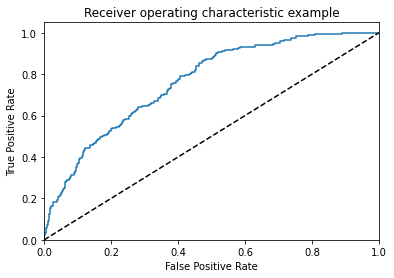

In [78]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')  # diagonal line
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
plt.show()

In [79]:
roc_auc

0.7617490842490842

    Confusion                 Predicted
    Matrix               Positive    Negative
              Positive      TP          FN
    Actual    Negative      FP          TN

In [80]:
cm = confusion_matrix(y_test, y_pred)

In [81]:
cm_df = pd.DataFrame(cm,
                     index=['Positive', 'Negative'],
                     columns=['Positive', 'Negative'])
display(cm_df)

,Positive,Negative
Positive,1809,11
Negative,172,8


In [82]:
beta = .1
fb_score = fbeta_score(y_test, y_pred, beta=beta)
fb_score

0.3884615384615384

In [83]:
beta = .01
fb_score = fbeta_score(y_test, y_pred, beta=beta)
fb_score

0.42069618256388686

In [84]:
math.prod([len(i) for i in parm.values()])

162

# 11. Features' importance

## 11.1. SHAP

In [85]:
%%script echo
# InvalidModelError: Model type not yet supported by TreeExplainer:
# <class 'imblearn.pipeline.Pipeline'>
explainer = shap.TreeExplainer(gs.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Couldn't find program: 'echo'


In [86]:
# MemoryError: Unable to allocate 148. GiB for an array with shape
# (3312, 5984000) and data type float64
K = 100
X_train_sample = shap.sample(X_train, K)
print(X_train_sample.shape)
explainer = shap.KernelExplainer(gs.best_estimator_.predict_proba, X_train_sample)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

(100, 748)


  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 11.2. LIME

# Annexes

In [ ]:
print("Precision:",
      precision_score(rs.predict(X_test), y_test))
      # precision_score(rs.best_estimator_.predict(X_test), y_test))
print("Recall:",
      recall_score(rs.best_estimator_.predict(X_test), y_test))
print("ROC AUC Score:",
      roc_auc_score(rs.best_estimator_.predict(X_test), y_test))

In [ ]:
plot la courbe roc du meilleur pour chaque sampler

In [ ]:
shap (et lime)

In [ ]:
%%script echo
#rs_cv.fit(X_train, y_train)
#rs_cv.fit(X_train_u, y_train_u)
rs_cv.fit(X_train_o, y_train_o)

for algorithm in classifiers.keys():
    print(f"Best parameters for {algorithm}: {rs_cv.best_params_[algorithm]}")
    print(f"Best AUC score for {algorithm}: {rs_cv.best_score_[algorithm]['roc_auc']:.3f}")
    print(f"Best accuracy score for {algorithm}: {rs_cv.best_score_[algorithm]['accuracy']:.3f}")

#best_algorithm = rs_cv.best_estimator_.keys()[0]
best_algorithm = rs_cv.best_estimator_.named_steps.keys()
print(f"Overall best algorithm: {best_algorithm}")
print(f"Best AUC score: {rs_cv.best_score_[best_algorithm]['roc_auc']:.3f}")
print(f"Best accuracy score: {rs_cv.best_score_[best_algorithm]['accuracy']:.3f}")

In [ ]:
rs.predict(X_test).shape

In [ ]:
y_test.shape